# Image classification

In [1]:
import torch
from torch import Generator

# Set the random seed for reproducibility
random_state = 42

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Preprocessing

In [3]:
import os
from data import train_val_split

base_dir = './data/train'
train_dir = './data/preprocessed/train'
val_dir = './data/preprocessed/val'

val_ratio = 0.2

if not os.path.exists(train_dir) and not os.path.exists(val_dir):
    train_val_split(base_dir, train_dir, val_dir, val_ratio, random_state) 

    print("Saved train data to:", train_dir)
    print("Saved validation data to:", val_dir)
else:
    print("Train and validation directories already exist.")

Train and validation directories already exist.


## Data

In [4]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset
from data import sample_dataset

default_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

augmented_transform = transforms.Compose([
    transforms.RandomCrop(64, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_default_ds = ImageFolder(train_dir, transform=default_transform)
train_augmented_ds = ImageFolder(train_dir, transform=augmented_transform)
train_ds = ConcatDataset([train_default_ds, train_augmented_ds])

val_ds = ImageFolder(val_dir, transform=default_transform)

# downsample the dataset
sample_ratio = 0.5
sampled_train_ds = sample_dataset(train_ds, sample_ratio, seed=random_state)
sampled_val_ds = sample_dataset(val_ds, sample_ratio, seed=random_state)

num_classes = len(train_default_ds.classes)

print(f"Number of training samples: {len(sampled_train_ds)}")
print(f"Number of validation samples: {len(sampled_val_ds)}")

batch_size = 128
num_workers = 0

# setup data loaders
train_dl = DataLoader(sampled_train_ds,
                      batch_size=batch_size,
                      num_workers=num_workers,
                      shuffle=True,
                      generator=Generator().manual_seed(random_state))

val_dl = DataLoader(sampled_val_ds,
                    batch_size=batch_size,
                    num_workers=num_workers, 
                    shuffle=False)

Number of training samples: 70409
Number of validation samples: 8801


Sample image shape: torch.Size([3, 64, 64])
Sample label: 0


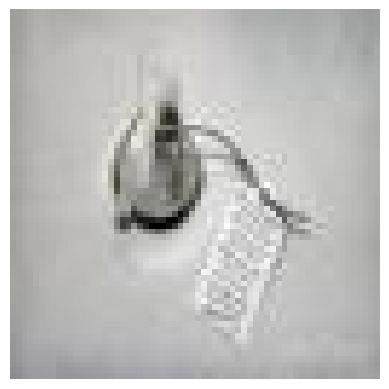

In [5]:
from utils import show_image

sample_img, sample_label = train_ds[0]

print(f"Sample image shape: {sample_img.size()}")
print(f"Sample label: {sample_label}")

show_image(sample_img)


## Training

In [6]:
from training import Trainer
import torch.optim as optim

### BasicModel

In [7]:
from models import BasicNet

basicNet = BasicNet(num_classes=num_classes)

optimizer = optim.Adam(basicNet.to(device).parameters(), lr=1e-4, weight_decay=1e-5)

trainer = Trainer(basicNet, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=30)

Epoch 1/30 (training):   1%|▏         | 8/551 [00:01<01:37,  5.54it/s]


KeyboardInterrupt: 

### Using AvgPool

In [ ]:
from models import AVGPoolNet_Kernel5

basicNet = AVGPoolNet_Kernel5(num_classes=num_classes)

optimizer = optim.Adam(basicNet.to(device).parameters(), lr=1e-4, weight_decay=1e-5)

trainer = Trainer(basicNet, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=30)

Epoch 1/30 (validation): 100%|██████████| 69/69 [00:10<00:00,  6.50it/s]


Epoch 1/30: Train Loss: 3.5953, Val Loss: 3.1769, Avg Class Accuracy: 0.1608


Epoch 2/30 (training):  38%|███▊      | 209/551 [00:29<00:47,  7.14it/s]


KeyboardInterrupt: 

In [9]:
from models import AVGPoolNet_Kernel3

basicNet = AVGPoolNet_Kernel3(num_classes=num_classes)

optimizer = optim.Adam(basicNet.to(device).parameters(), lr=1e-4, weight_decay=1e-5)

trainer = Trainer(basicNet, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=30)

Epoch 1/30 (validation): 100%|██████████| 69/69 [00:09<00:00,  7.35it/s]


Epoch 1/30: Train Loss: 3.5890, Val Loss: 3.1593, Avg Class Accuracy: 0.1632


Epoch 2/30 (validation): 100%|██████████| 69/69 [00:09<00:00,  7.37it/s]


Epoch 2/30: Train Loss: 3.2124, Val Loss: 2.9151, Avg Class Accuracy: 0.2320


Epoch 3/30 (training):   1%|          | 4/551 [00:00<01:46,  5.13it/s]


KeyboardInterrupt: 

#### Not using pooling

In [ ]:
from models import No_PoolNet

basicNet = No_PoolNet(num_classes=num_classes)

optimizer = optim.Adam(basicNet.to(device).parameters(), lr=1e-4, weight_decay=1e-5)

trainer = Trainer(basicNet, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=30)

Epoch 1/30 (validation): 100%|██████████| 69/69 [00:09<00:00,  7.21it/s]


Epoch 1/30: Train Loss: 3.6755, Val Loss: 3.3080, Avg Class Accuracy: 0.1426


Epoch 2/30 (training):   4%|▎         | 20/551 [00:02<01:15,  7.03it/s]


KeyboardInterrupt: 

### Renset-like model

In [ ]:
from models import SimpleResNet

simpleResNet = SimpleResNet(num_classes=num_classes)

optimizer = optim.Adam(simpleResNet.to(device).parameters(), lr=1e-3, weight_decay=1e-5)

trainer = Trainer(simpleResNet, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=30)

### Four-block CNN

In [ ]:
from models import FourBlockCNN

fourBlockCNN = FourBlockCNN(num_classes=50)

optimizer = optim.Adam(fourBlockCNN.to(device).parameters(), lr=1e-3, weight_decay=1e-5)

trainer = Trainer(fourBlockCNN, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=30)

# Results:
# Without augmentation: Epoch 10/10: Train Loss: 2.2281, Val Loss: 2.4054, Avg Class Accuracy: 0.3387
# With augmentation: Epoch 10/10: Train Loss: 1.7477, Val Loss: 1.8611, Avg Class Accuracy: 0.4847

## Resnet18

Here we train the ResNet18 model on the dataset to see the state of the art performance.

In [ ]:
import torch.nn as nn

resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

in_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(in_features, num_classes)

resnet18 = resnet18.to(device)

optimizer = optim.Adam(resnet18.parameters(), lr=1e-4, weight_decay=1e-5)

trainer = Trainer(resnet18, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=30)